In [48]:
import requests
import os
import xarray as xr
import polars as pl
import pandas as pd
import plotly.express as px

In [49]:


def download_file(url, directory, filename):
    """
    Downloads a file from a given URL and saves it to a specified directory with the given filename.
    
    Args:
        url (str): URL of the file to be downloaded.
        directory (str): Directory path where the file will be saved.
        filename (str): Name of the file to be saved as.

    Returns:
        None
    """
    # Ensure the directory exists
    os.makedirs(directory, exist_ok=True)
    
    # Make a GET request to download the data
    response = requests.get(url)
    
    # Full path to where the file will be saved
    full_path = os.path.join(directory, filename)
    
    # Check if the request was successful
    if response.status_code == 200:
        with open(full_path, "wb") as f:
            f.write(response.content)
        print(f"File {filename} downloaded successfully!")
    else:
        print(f"Failed to download {filename}. Status code: {response.status_code}")

# URLs and corresponding filenames
files_to_download = {
    "https://climexp.knmi.nl/data/inino12_daily.nc": "inino12_daily.nc",
    "https://climexp.knmi.nl/data/inino3_daily.nc": "inino3_daily.nc",
    "https://climexp.knmi.nl/data/inino34_daily.nc": "inino34_daily.nc",
    "https://climexp.knmi.nl/data/inino4_daily.nc": "inino4_daily.nc"
}

# Directory to save the downloaded files
directory = "/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/enso"

# Download each file
for url, filename in files_to_download.items():
    download_file(url, directory, filename)



File inino12_daily.nc downloaded successfully!
File inino3_daily.nc downloaded successfully!


File inino34_daily.nc downloaded successfully!
File inino4_daily.nc downloaded successfully!


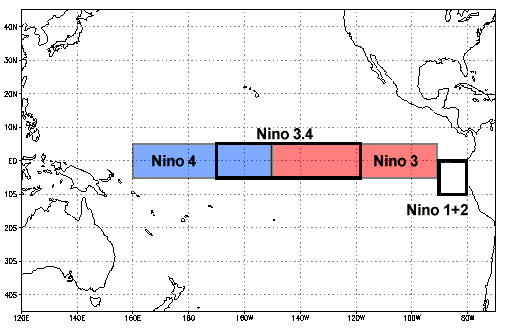

In [34]:


def visualize_nino_data(dataset, variable_name):
    """
    Visualizes the specified variable from an xarray.Dataset using Plotly.

    Args:
        dataset (xarray.Dataset): The dataset containing the variable to visualize.
        variable_name (str): Variable name in the dataset to visualize.

    Returns:
        None
    """
    # Check if the variable exists in the dataset
    if variable_name in dataset:
        # Convert the specified xarray DataArray to a pandas DataFrame for easier plotting with Plotly
        data_df = dataset[variable_name].to_dataframe().reset_index()
        
        # Create an interactive line plot
        fig = px.line(data_df, x='time', y=variable_name, title=f'Daily {variable_name} Index',
                      labels={variable_name: 'Temperature Anomaly (K)', 'time': 'Time'})
        fig.update_layout(xaxis_title='Time', yaxis_title='Temperature Anomaly (K)', showlegend=False)
        fig.show()
    else:
        print(f"Variable '{variable_name}' not found in the dataset.")

# # Example usage:
# data = xr.open_dataset('/path/to/your/nino_dataset.nc')
# visualize_nino_data(data, 'Nino12')


In [50]:
# Example usage:
data_nino12 = xr.open_dataset('/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/enso/inino12_daily.nc')
visualize_nino_data(data_nino12, 'Nino12')

In [53]:
# Example usage:
# Assuming 'data' is an xarray.Dataset already loaded with the required data
data_nino3 = xr.open_dataset('/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/enso/inino3_daily.nc')
visualize_nino_data(data_nino3, 'Nino3')

In [51]:
# Example usage:
# Assuming 'data' is an xarray.Dataset already loaded with the required data
data_nino34 = xr.open_dataset('/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/enso/inino34_daily.nc')
visualize_nino_data(data_nino34, 'Nino34')

In [52]:
# Example usage:
# Assuming 'data' is an xarray.Dataset already loaded with the required data
data_nino4 = xr.open_dataset('/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/enso/inino4_daily.nc')
visualize_nino_data(data_nino4, 'Nino4')

In [54]:
import xarray as xr
import pandas as pd
import polars as pl

def process_and_convert(dataset, variable_name, start_date='1981-09-01'):
    # Find the maximum valid date dynamically
    max_valid_date = dataset[variable_name].dropna(dim='time', how='all').time.max().values
    
    # Trim the dataset from the first known valid date to the last known valid date
    valid_data = dataset.sel(time=slice(start_date, max_valid_date))
    
    # Convert the trimmed xarray Dataset to a pandas DataFrame
    df_valid = valid_data[variable_name].to_dataframe(name=variable_name)
    
    # Reset the index to convert the datetime index into a regular column
    df_valid_reset = df_valid.reset_index()
    
    # Convert the pandas DataFrame with reset index to a Polars DataFrame
    pl_valid = pl.from_pandas(df_valid_reset)
    
    return pl_valid

# Process each dataset
pl_nino12 = process_and_convert(data_nino12, 'Nino12')
pl_nino3 = process_and_convert(data_nino3, 'Nino3')
pl_nino34 = process_and_convert(data_nino34, 'Nino34')
pl_nino4 = process_and_convert(data_nino4, 'Nino4')


In [55]:
def merge_datasets(*datasets):
    # Initial dataset to start merging from
    merged_df = datasets[0]
    
    # Iterate over remaining datasets and merge them one by one
    for data in datasets[1:]:
        # Use Polars' join function with a custom suffix to prevent name clashes
        merged_df = merged_df.join(data, on="time", how="outer", suffix="_right")
        
        # If '_right' columns are created (which contain the same data), drop them
        # and ensure no duplicate 'time' columns remain
        if 'time_right' in merged_df.columns:
            merged_df = merged_df.drop('time_right')

    return merged_df

    # Merge the dataframes
pl_merged = merge_datasets(pl_nino12, pl_nino3, pl_nino34, pl_nino4)

In [56]:
pl_merged

shape: (15_598, 5)
┌─────────────────────┬───────────┬───────────┬───────────┬───────────┐
│ time                ┆ Nino12    ┆ Nino3     ┆ Nino34    ┆ Nino4     │
│ ---                 ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ datetime[ns]        ┆ f32       ┆ f32       ┆ f32       ┆ f32       │
╞═════════════════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1981-09-01 00:00:00 ┆ 0.05473   ┆ -0.033769 ┆ -0.033502 ┆ -0.087432 │
│ 1981-09-02 00:00:00 ┆ 0.125351  ┆ -0.068272 ┆ -0.045651 ┆ -0.085928 │
│ 1981-09-03 00:00:00 ┆ 0.20493   ┆ -0.132351 ┆ -0.089331 ┆ -0.061235 │
│ 1981-09-04 00:00:00 ┆ -0.08833  ┆ -0.228514 ┆ -0.27863  ┆ -0.166646 │
│ 1981-09-05 00:00:00 ┆ -0.346005 ┆ -0.255113 ┆ -0.333117 ┆ -0.287201 │
│ …                   ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2024-05-11 00:00:00 ┆ -0.753336 ┆ 0.183753  ┆ 0.428211  ┆ 0.852668  │
│ 2024-05-12 00:00:00 ┆ -1.24461  ┆ 0.033529  ┆ 0.428645  ┆ 0.897592  │
│ 2024-05-13 00:00:00 ┆ -1.067266 ┆ -0.029715 ┆ 0.370251  ┆ 0.867582  │
│ 2024-05-14 00:00:00 ┆ -0.94649  ┆ -0.097207 ┆ 0.334956  ┆ 0.869546  │
│ 2024-05-15 00:00:00 ┆ -0.854944 ┆ -0.112678 ┆ 0.321168  ┆ 0.838484  │
└─────────────────────┴───────────┴───────────┴───────────┴───────────┘

In [57]:
pl_merged.write_parquet("/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/merged_nino_data.parquet")

In [58]:
import shutil

# Specify the path of the directory
directory_path = '/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/enso'

# Remove the directory and all its contents
shutil.rmtree(directory_path)
